<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Introduction


Try to predict direction of following period's return using contextual bandits.

The idea is to train an agent who can learn to trade using historical price action.

# Libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
from vowpalwabbit import pyvw

In [3]:
import pyfolio as pf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


# Setup

In [4]:
%cd ..

/tmp/trading


In [5]:
data_dir = Path("./data")

# Data

Load the data:

In [6]:
train = pd.read_parquet(data_dir / "train.parquet")
test = pd.read_parquet(data_dir / "test.parquet")

In [7]:
test_start_date = min(test.index).to_datetime64()
test_start_date

numpy.datetime64('2018-01-05T21:01:00.000000000')

In [8]:
df = pd \
    .concat([train, test]) \
    .asfreq("D") \
    .sort_index(ascending=True)

df["log_returns"] = np.log(df["Close"]/df["Close"].shift(1))
df.head()

,Open,Close,High,Low,Trades,Volume,log_returns
Date,,,,,,,
2017-12-31 21:00:00+00:00,14185.5,14176.0,14187.0,14170.5,51,101296,NaN
2018-01-01 21:00:00+00:00,13501.5,13487.5,13501.0,13478.0,193,243808,-0.049787
2018-01-02 21:00:00+00:00,14872.5,14874.0,14889.5,14872.0,281,1067619,0.097851
2018-01-03 21:00:00+00:00,15002.5,15022.0,15025.5,15002.5,179,650992,0.009901
2018-01-04 21:00:00+00:00,14905.5,14909.5,14920.0,14882.5,295,1303421,-0.007517


# Feature Engineering

In [9]:
returns = df["Close"].pct_change(periods=1).dropna().rename("return_t")
labels = returns.apply(lambda r: 1 if r > 0 else -1).rename("label_t")

In [10]:
context_length = 5

# the "m" means minus ie tm2 = t-2
context_features = [returns.rolling(context_length).apply(lambda s: s[i-1]).rename(f"tm{-(i-1-(context_length-1))}") 
                    for i in range(context_length, 0, -1)]
feature_columns = [context_feature.name for context_feature in context_features]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


In [11]:
feat = pd.concat([returns, labels, *context_features], axis=1)
feat["label_tp1"] = feat["label_t"].shift(periods=-1)
feat = feat.dropna()

feat.head()

,return_t,label_t,tm0,tm1,tm2,tm3,tm4,label_tp1
Date,,,,,,,,
2018-01-05 21:00:00+00:00,0.112110,1,0.112110,-0.007489,0.009950,0.102799,-0.048568,1.0
2018-01-06 21:00:00+00:00,0.016977,1,0.016977,0.112110,-0.007489,0.009950,0.102799,-1.0
2018-01-07 21:00:00+00:00,-0.039437,-1,-0.039437,0.016977,0.112110,-0.007489,0.009950,-1.0
2018-01-08 21:00:00+00:00,-0.078129,-1,-0.078129,-0.039437,0.016977,0.112110,-0.007489,-1.0
2018-01-09 21:00:00+00:00,-0.009510,-1,-0.009510,-0.078129,-0.039437,0.016977,0.112110,-1.0


# Modelling

Note:
* **Actions**: 1 means Long, 2 means Short

In [12]:
import src.cb as cb

In [13]:
vw = pyvw.vw("--cb_explore 2 --cover 50 --quiet -q :: --random_seed 123")

In [14]:
total_reward = 0
for row_tuple in feat.query("Date < @test_start_date").itertuples():
    features = cb.extract_features_from_row_tuple(row_tuple, feature_columns)
    pmf = vw.predict(features)
    action, prob = cb.sample_an_action(pmf)
    label = row_tuple.label_tp1
    cost = cb.compute_cost(action, label)
    example = cb.build_example(action, cost, prob, features)
    
    total_reward = total_reward + (-cost)
    
    vw.learn(example)

print(total_reward)

1


/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


# Evaluation

In [15]:
actions = []
probs = []

In [16]:
total_reward = 0
for row_tuple in feat.query("Date >= @test_start_date").itertuples():
    features = cb.extract_features_from_row_tuple(row_tuple, feature_columns)
    pmf = vw.predict(features)
    action, prob = cb.sample_an_action(pmf)
    label = row_tuple.label_tp1
    cost = cb.compute_cost(action, label)
    example = cb.build_example(action, cost, prob, features)
    
    total_reward = total_reward + (-cost)
    
    actions.append(action)
    probs.append(prob)
    
    vw.learn(example)


print(total_reward)
vw.finish()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


298


In [17]:
eval_df = feat.query("Date >= @test_start_date")

eval_df["action"] = actions
eval_df["prob"] = probs

# action is determined at the end of the day, so we
# can only act on it at the start of the following day
eval_df["signal"] = eval_df["action"].shift(1)

eval_df = eval_df.dropna()

# 1 is long, -1 is short
eval_df["signal"] = eval_df["signal"].apply(lambda a: 1 if a == 1 else -1)

eval_df = eval_df.join(df["log_returns"])

eval_df["strategy_returns"] = eval_df["signal"] * eval_df["log_returns"]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports 

Percentage returns:

In [18]:
np.exp(eval_df["strategy_returns"].sum()) - 1

1.608841789654202

Plot the returns:

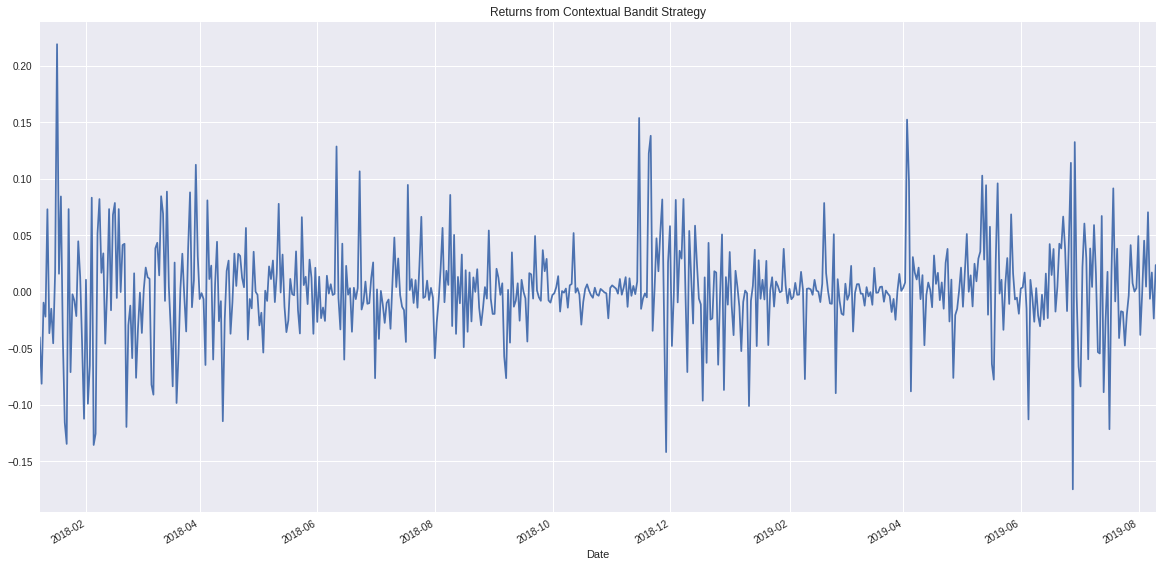

In [19]:
eval_df["strategy_returns"].plot(figsize=(20, 10), title="Returns from Contextual Bandit Strategy")

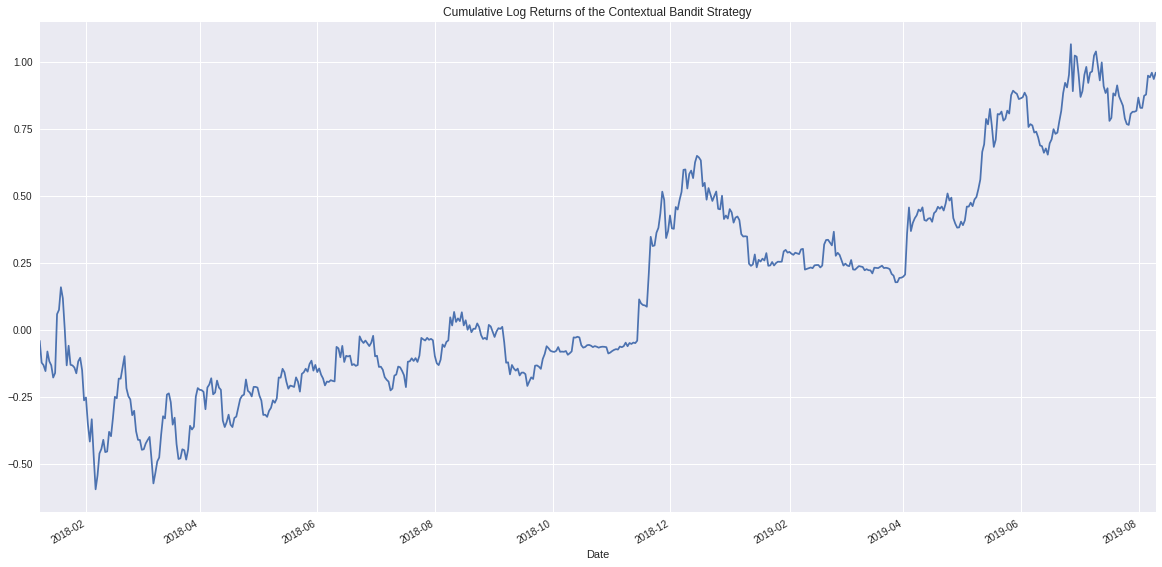

In [20]:
eval_df["strategy_returns"].cumsum() \
    .plot(figsize=(20, 10), title="Cumulative Log Returns of the Contextual Bandit Strategy")

Detailed analysis on the Contextual Bandit Strategy:

Start date,2018-01-07
End date,2019-08-09
Total months,27
,Backtest
Annual return,51.7%
Cumulative returns,160.9%
Annual volatility,68.1%
Sharpe ratio,0.95
Calmar ratio,0.98
Stability,0.82
Max drawdown,-52.9%


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.91,2018-01-18,2018-02-05,2018-11-19,218
1,37.58,2018-12-14,2019-03-27,2019-05-11,106
2,25.97,2019-06-26,2019-07-26,NaT,NaN
3,21.21,2019-05-27,2019-06-14,2019-06-23,20
4,15.88,2018-11-26,2018-11-28,2018-12-07,10


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


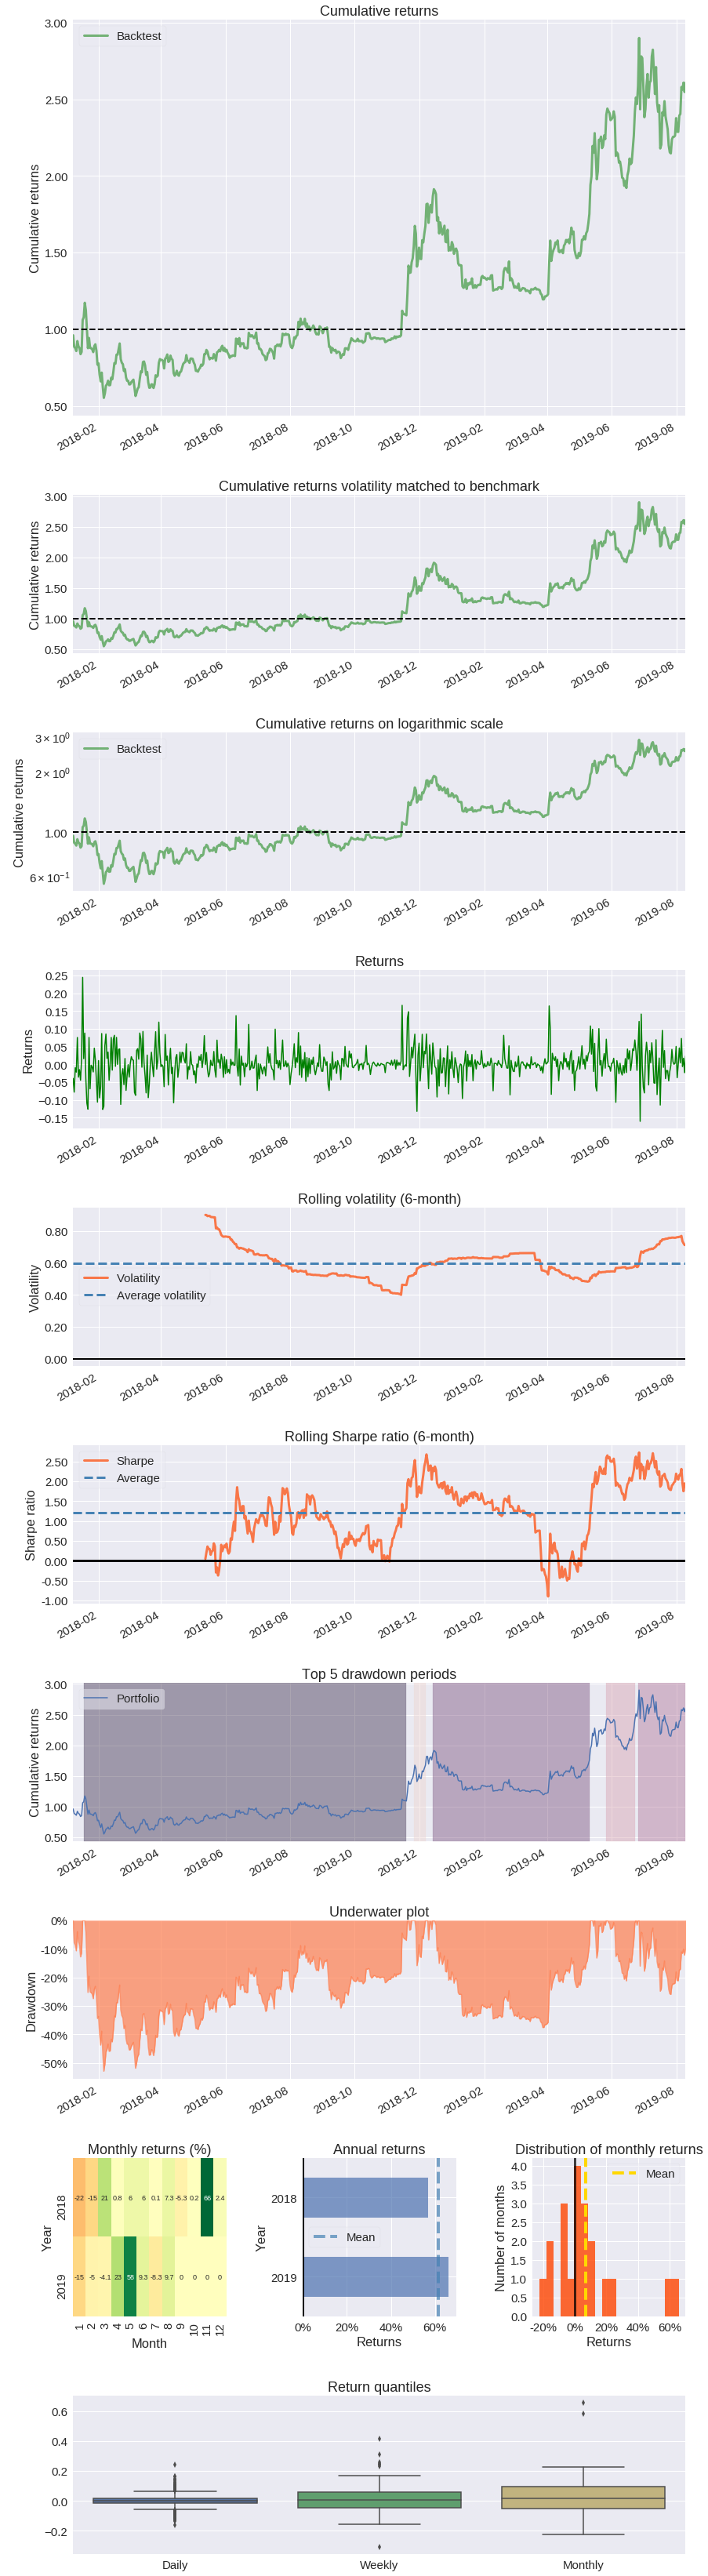

In [21]:
pf.create_returns_tear_sheet(np.exp(eval_df["strategy_returns"]) - 1)

Distribution of returns over many trials:

In [22]:
%%time
trials = 50
returns = []



for trial in range(trials):
    
    if trial % 10 == 0:
        print(f"Simulating trial {trial+1} of {trials} ...")
    
    vw = pyvw.vw("--cb_explore 2 --cover 50 --quiet -q :: --random_seed 123")
    actions = []
    probs = []
    
    for row_tuple in feat.query("Date >= @test_start_date").itertuples():
        features = cb.extract_features_from_row_tuple(row_tuple, feature_columns)
        pmf = vw.predict(features)
        action, prob = cb.sample_an_action(pmf)
        label = row_tuple.label_tp1
        cost = cb.compute_cost(action, label)
        example = cb.build_example(action, cost, prob, features)

        total_reward = total_reward + (-cost)

        actions.append(action)
        probs.append(prob)

        vw.learn(example)

    eval_df = feat.query("Date >= @test_start_date")

    eval_df["action"] = actions
    eval_df["prob"] = probs

    # action is determined at the end of the day, so we
    # can only act on it at the start of the following day
    eval_df["signal"] = eval_df["action"].shift(1)

    eval_df = eval_df.dropna()

    # 1 is long, -1 is short
    eval_df["signal"] = eval_df["signal"].apply(lambda a: 1 if a == 1 else -1)

    eval_df = eval_df.join(df["log_returns"])

    eval_df["strategy_returns"] = eval_df["signal"] * eval_df["log_returns"]

    ret = np.exp(eval_df["strategy_returns"].sum()) - 1

    returns.append(ret)
    vw.finish()

returns = pd.Series(returns)

Simulating trial 1 of 50 ...


/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33

Simulating trial 11 of 50 ...
Simulating trial 21 of 50 ...
Simulating trial 31 of 50 ...
Simulating trial 41 of 50 ...
CPU times: user 3min 29s, sys: 66.3 ms, total: 3min 29s
Wall time: 3min 29s


In [23]:
returns.describe()

count    50.000000
mean      1.988099
std       2.136734
min      -0.715367
25%       0.626254
50%       1.721171
75%       2.647202
max      11.995618
dtype: float64

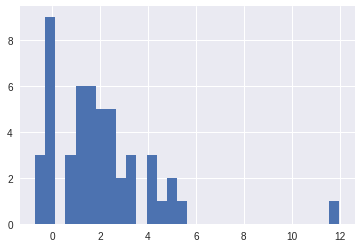

In [24]:
returns.hist(bins=30)

In [25]:
(returns < 0).mean()

0.16